# Unsupervised Black-Scholes PINN for European call and American put options

This modified version builds on the 
**[ this original notebook](https://github.com/PieroPaialungaAI/BlackScholesPINN/blob/main/example/BlackScholesModel.ipynb)**
by simplifying the training setup, removing the need for labeled data, and incorporating boundary logic. 
In addition, it extends the formulation to include a free boundary condition, allowing the model to handle American options. 
The theoretical foundation for this extension follows the treatment in **[ American Option Lecture Notes (Byott, 2005)}](https://empslocal.ex.ac.uk/people/staff/NPByott/teaching/FinMaths/2005/american.pdf)**.




## Black-Scholes Equation for European Call Option

The Black-Scholes PDE models the price $C(S, t)$ of a European call option as it evolves over time:


$$
\frac{\partial C}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + r S \frac{\partial C}{\partial S} - r C = 0,
$$

where
- $ S $: stock price  
- $ t $: time 
- $ \sigma $: volatility  
- $ r $: risk-free interest rate  
- $ C $: option price


This equation captures how the option’s value evolves over time, balancing the effects of time decay, volatility, and interest rates. In this project, the PINN learns to approximate $ C(S, t) $ by minimizing the residual of this PDE, guided by boundary and terminal (initial) conditions — without relying on labeled data.

To validate the learned solution, we compare it against the well-known analytic formula for European call options:

$$
C(S, t) = S \cdot N(d_1) - K e^{-r (T - t)} \cdot N(d_2),
$$

with 

$$
d_1 = \frac{\ln(S / K) + (r + \frac{1}{2} \sigma^2)(T - t)}{\sigma \sqrt{T - t}}, \quad
d_2 = d_1 - \sigma \sqrt{T - t},
$$

where
- $ K $: Strike price 
- $ T $: Time to maturity 
- $ N $: Cumulative distribution function (CDF) of the standard normal distribution, representing the probability that a standard normal variable is less than or equal to its argument

### Unsupervised PINN setup
No labeled data is required — the solution is learned directly from the PDE and the specified boundary and terminal conditions.

  

- **Terminal condition**  
  

$$
  C_{\theta}(S, T) = \max(S - K, 0).
$$

  
  Implemented via `np.maximum`, this reflects the exact payoff structure of a European call option.

- **Boundary conditions**

$$
  C_{\theta}(S_{\text{min}}, t) = 0,
$$


and if we consider the upper boundary using the analytic solution

$$
    C_{\theta}(S_{\text{max}}, t) = C(S_{\text{max}}, t).
$$

However, in this notebook, we explore using the derivative of the boundary condition as a constraint to avoid relying on the analytic Black-Scholes solution.

### Neumann Boundary Condition and Delta

At large stock prices $S$, the option price satisfies the **Neumann boundary condition**:

$$
\left. \frac{\partial C}{\partial S} \right|_{S \to \infty} \approx 1
$$

This expresses that the **option delta** approaches 1 for deep in-the-money calls, under the assumption that the observational noise is statistically independent of the underlying asset price

From the Black–Scholes model,
$$
\Delta = \frac{\partial C}{\partial S} = N(d_1).
$$

Under the condition that volatility $σ$ is small and/or $S \gg K$,
$d_1$ becomes large and positive, giving

$$
N(d_1) \approx 1.
$$

Hence, the call price rises nearly one-for-one with the stock price, the option behaves like owning the stock itself.

Accordingly, this condition is imposed as the upper boundary in the PINN:
$$
  \frac{\partial C_{\theta}}{\partial S}(S_{\max}, t) = 1.
$$



## Training



In [1]:
from black_scholes import *
import json
from utils import *
import matplotlib.pyplot as plt

with open("config.json") as f:
    allconfig = json.load(f)


### European Call Option

In [14]:
config = allconfig["euro_call"]
bs = EuropeanPINN(config)
bs.train()

Epoch 0 | Total: 85.569641 | Terminal: 83.183472 | Boundary: 2.386073 | PDE: 0.000097
Epoch 200 | Total: 11.997274 | Terminal: 10.204879 | Boundary: 1.183307 | PDE: 0.609089
Epoch 400 | Total: 2.377868 | Terminal: 1.314849 | Boundary: 0.825361 | PDE: 0.237658
Epoch 600 | Total: 1.223923 | Terminal: 0.522139 | Boundary: 0.640379 | PDE: 0.061405
Epoch 800 | Total: 0.949592 | Terminal: 0.388317 | Boundary: 0.526085 | PDE: 0.035190
Epoch 1000 | Total: 0.811906 | Terminal: 0.346423 | Boundary: 0.438933 | PDE: 0.026549
Epoch 1200 | Total: 0.715325 | Terminal: 0.316575 | Boundary: 0.374403 | PDE: 0.024347
Epoch 1400 | Total: 0.643959 | Terminal: 0.302219 | Boundary: 0.322975 | PDE: 0.018765
Epoch 1600 | Total: 0.592713 | Terminal: 0.291032 | Boundary: 0.288314 | PDE: 0.013367
Epoch 1800 | Total: 0.560943 | Terminal: 0.282294 | Boundary: 0.268555 | PDE: 0.010094
Epoch 2000 | Total: 0.542938 | Terminal: 0.275451 | Boundary: 0.259109 | PDE: 0.008378
Epoch 2200 | Total: 0.531833 | Terminal: 0.270


After training, the model can be evaluated against the analytic solution across the time horizon from $t=1$ to $0$. However, the primary goal is to accurately predict option prices at $t=0$, which corresponds to the present value of the European call option.




In [15]:
t = 0
S_eval, t_eval = prepare_dataset(config, time=t)
C_pred = bs.predict(S_eval, t_eval).numpy()


### Comparing PINN vs Black Scholes solution

To assess how well the network has learned the pricing function, we visualize the PINN predictions alongside the analytic Black-Scholes solution, including added noise. The mean squared error (MSE) between the predicted and noisy option prices at time $t$ provides a quantitative measure of accuracy — typically demonstrating strong alignment, even without any supervised training data..


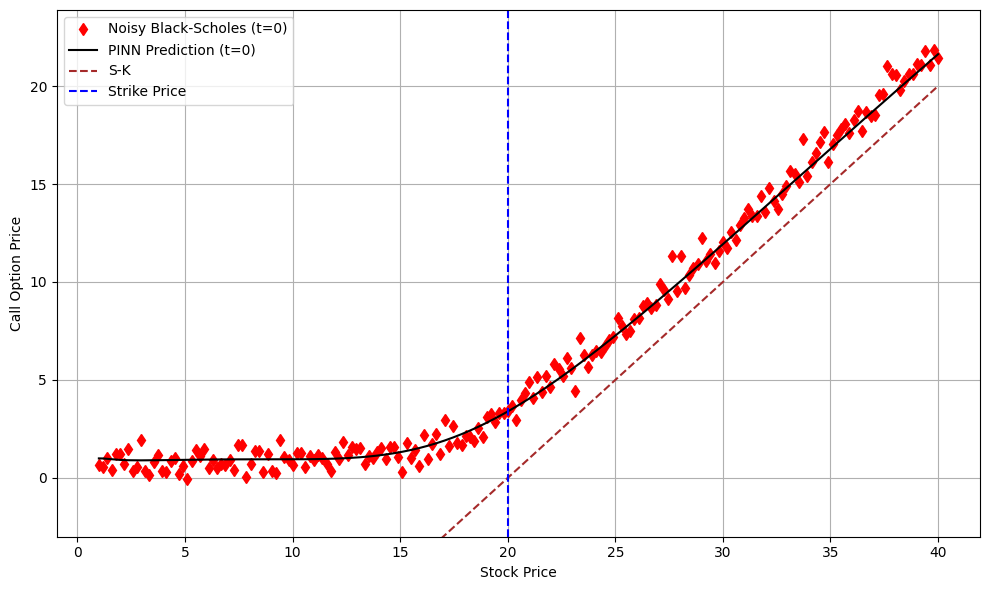

Mean Squared Error (MSE): 91.40069562327676


In [16]:
S_np = S_eval.numpy().flatten()
epsilon = 1e-8 # Small constant to prevent division by zero
C_true = black_scholes_call_solution(S_np, config["K"], config["T"]- t + epsilon , config["r"], config["sigma"])
C_true += np.random.normal(config["bias"] , config["noise_variance"], size=C_true.shape)
plt.figure(figsize=(10, 6))
plt.plot(S_np, C_true, 'd', label="Noisy Black-Scholes (t=0)",color='red')
plt.plot(S_np, C_pred, label="PINN Prediction (t=0)", color='k')
plt.plot(S_np, S_np - config["K"], linestyle='--', label="S-K",color='brown')
plt.axvline(x=config["K"], color='blue', linestyle='--', label=f"Strike Price")

plt.xlabel('Stock Price')
plt.ylabel('Call Option Price')
plt.ylim(bottom=-3)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse = np.mean((C_true - C_pred) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

## American Put Option

The American put option differs from its European counterpart because it may be exercised at any time before maturity.
This flexibility introduces a free boundary problem, where an optimal exercise boundary $S_f$ divides the domain into two regions — exercise and continuation.

### Governing Equation

To price an American put option, we seek a function $V(S,t)$ and a boundary $S_f$ satisfying $0 \le S_f \le K = S_f(T)$, such that for all $S$:

$$
\dfrac{\partial V}{\partial t}
+ \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2 V}{\partial S^2}
+ rS \dfrac{\partial V}{\partial S}
- rV \le 0,
$$

and

$$
V(S,t) \ge \max(K - S, 0).
$$

These two inequalities express that the option value $V$ must always be at least as large as the immediate exercise payoff, while the Black–Scholes differential operator is non-positive.


The corresponding loss terms in the PINN formulation can be defined as

$$
L_{\text{PDE}} = \frac{1}{N}\sum \text{ReLU}\!\left(
\dfrac{\partial V}{\partial t} + \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2 V_\theta}{\partial S^2}
+ rS \dfrac{\partial V_\theta}{\partial S}
- rV_\theta
\right),
$$

and

$$
L_{\text{Payoff}} = \frac{1}{N}\sum\text{ReLU}\!\left(
\max(K - S, 0) - V_\theta(S,t)
\right).
$$


### Exercise and Continuation Regions

Moreover, at least one of these inequalities must hold as an **equality** at every point, defining a **linear complementarity problem (LCP)**:

$$
\big( V(S, t) - \max(K - S, 0) \big)
\left(
\dfrac{\partial V}{\partial t}
+ \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2 V}{\partial S^2}
+ rS \dfrac{\partial V}{\partial S}
- rV
\right)
= 0.
$$

This can be interpreted as

$$
\begin{cases}
\text{If } S \le S_f, \\[6pt]
& V(S) = \max(K - S, 0) \quad \text{(exercise region)}, \\[10pt]
\text{If } S > S_f, \\[6pt]
& \dfrac{\partial V}{\partial t}
+ \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2 V}{\partial S^2}
+ rS \dfrac{\partial V}{\partial S}
- rV = 0 \quad \text{(continuation region)}.
\end{cases}
$$

Therefore, the complementarity loss can be expressed as

$$
L_{\text{Comp}} =\frac{1}{N}\sum
\left[\min\!\left(
V_\theta - \max(K - S, 0),\;
- \!\left(
\dfrac{\partial V}{\partial t}
+ \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2 V_\theta}{\partial S^2}
+ rS \dfrac{\partial V_\theta}{\partial S}
- rV_\theta
\right)
\right)\right]^2.
$$

Without the $\min$ operator, the loss might update only one side of the complementarity condition, failing to enforce the mutual exclusivity between the PDE and payoff constraints.


### Terminal and Boundary Conditions

The terminal condition for the American put option is the same as in the European market:  
at maturity, the option value equals its payoff.

- **Terminal condition**
  
$$
V_{\theta}(S, T) = \max(K - S, 0).
$$


- **Boundary conditions**

At the upper boundary, the option becomes worthless when the stock price is sufficiently high:
$$
V_{\theta}(S_{\max}, t) = 0.
$$

At the lower boundary, $S_{\min}$ lies within the exercise region ($S_{\min} \le S_f$),  
and the option value matches the payoff:
$$
V_{\theta}(S_{\min}, t) = K - S_{\min}.
$$

The slope at this boundary satisfies
$$
\frac{\partial V_{\theta}}{\partial S}(S_{\min}, t) = -1.
$$


In the European market, the Black–Scholes solution for a **put option** is

$$
V = S N(d_1) - K e^{-rT} N(d_2) - S + K e^{-rT}
= S (N(d_1) - 1) - K e^{-rT} (N(d_2) - 1),
$$

with the delta given by

$$
\frac{\partial V}{\partial S} = N(d_1) - 1.
$$

For deep in-the-money cases ($S \ll K$), we have $d_1 \ll 0$ and hence $N(d_1) \approx 0$, leading to

$$
\frac{\partial V_{\theta}}{\partial S}(S_{\min}, t) \approx -1,
$$
which meets the same value in **American put option**.

## Training

In [10]:
config = allconfig["us_put"]
bs_us = AmericanPutPINN(config)
bs_us.train()

Epoch 0 | Total: 738.599609 | Terminal: 362.961761 | Boundary: 1.969391 | PDE: 0.000069 | Payoff: 13.782630 | Complementarity: 359.885742
Epoch 200 | Total: 431.917328 | Terminal: 179.918839 | Boundary: 102.724625 | PDE: 0.000000 | Payoff: 7.183621 | Complementarity: 142.090240
Epoch 400 | Total: 431.473236 | Terminal: 179.916245 | Boundary: 102.725677 | PDE: 0.000000 | Payoff: 7.171795 | Complementarity: 141.659546
Epoch 600 | Total: 59.549458 | Terminal: 25.998354 | Boundary: 7.861416 | PDE: 0.000000 | Payoff: 2.482578 | Complementarity: 23.207108
Epoch 800 | Total: 0.946198 | Terminal: 0.265498 | Boundary: 0.245993 | PDE: 0.000000 | Payoff: 0.171766 | Complementarity: 0.262941
Epoch 1000 | Total: 0.885885 | Terminal: 0.256223 | Boundary: 0.251574 | PDE: 0.000000 | Payoff: 0.138658 | Complementarity: 0.239429
Epoch 1200 | Total: 0.903444 | Terminal: 0.257789 | Boundary: 0.252362 | PDE: 0.000000 | Payoff: 0.140203 | Complementarity: 0.253090
Epoch 1400 | Total: 0.929775 | Terminal: 0.

In [11]:
t = 0
S_eval, t_eval = prepare_dataset(config, time=t)
C_pred = bs_us.predict(S_eval, t_eval).numpy()

Compare it with the solutions generated by QuantLib and by the Black–Scholes analytical formula.

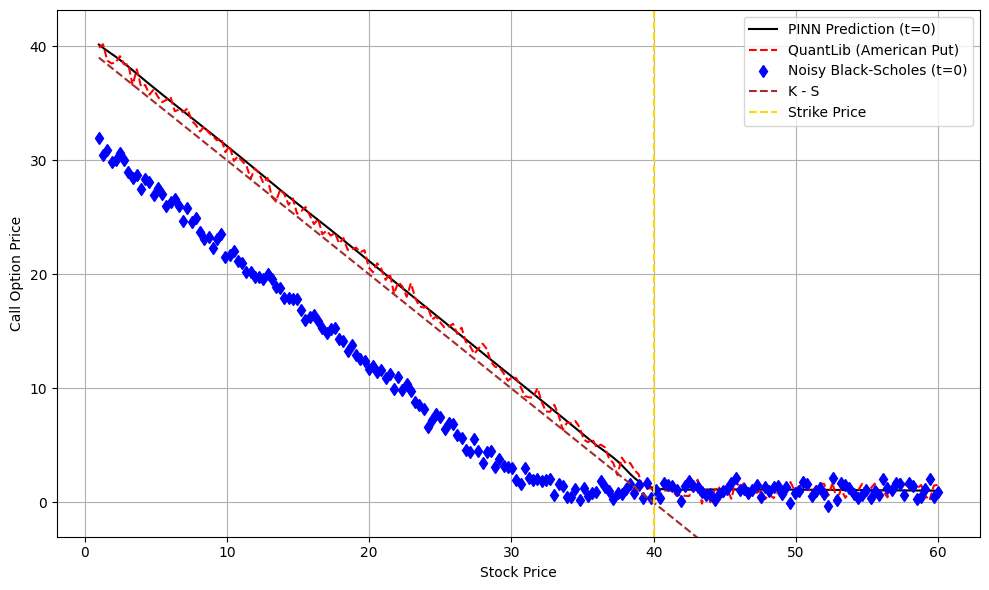

Mean Squared Error (MSE): 340.85612192978317


In [ ]:
S_np = S_eval.numpy().flatten()
prices = [
    american_put_ql(
        float(S),
        config["K"],
        config["r"],
        config["sigma"],
        config["T"],
        bias=config["bias"],
        noise_variance=config["noise_variance"]
    )
    for S in S_eval
]

epsilon = 1e-8 
C_BS = black_scholes_put_solution(S_np, config["K"], config["T"] -t + epsilon, config["r"], config["sigma"])
C_BS += np.random.normal(config["bias"] , config["noise_variance"], size=C_BS.shape)

plt.figure(figsize=(10, 6))
plt.plot(S_np, C_pred, label="PINN Prediction (t=0)", color='k')
plt.plot(S_np, prices, label="QuantLib (American Put)", color='red', linestyle='--')
plt.plot(S_np, C_BS, 'd', label="Noisy Black-Scholes (t=0)",color='blue')
plt.plot(S_np, config["K"] - S_np, linestyle='--', label="K - S",color='brown')
plt.axvline(x=config["K"], color='gold', linestyle='--', label=f"Strike Price")

plt.xlabel('Stock Price')
plt.ylabel('Call Option Price')
plt.ylim(bottom=-3)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse = np.mean((prices - C_pred) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

We can also check the training at the terminal condition 

In [5]:
t = 1
S_eval, t_eval = prepare_dataset(config, time=t)
C_pred = bs_us.predict(S_eval, t_eval).numpy()

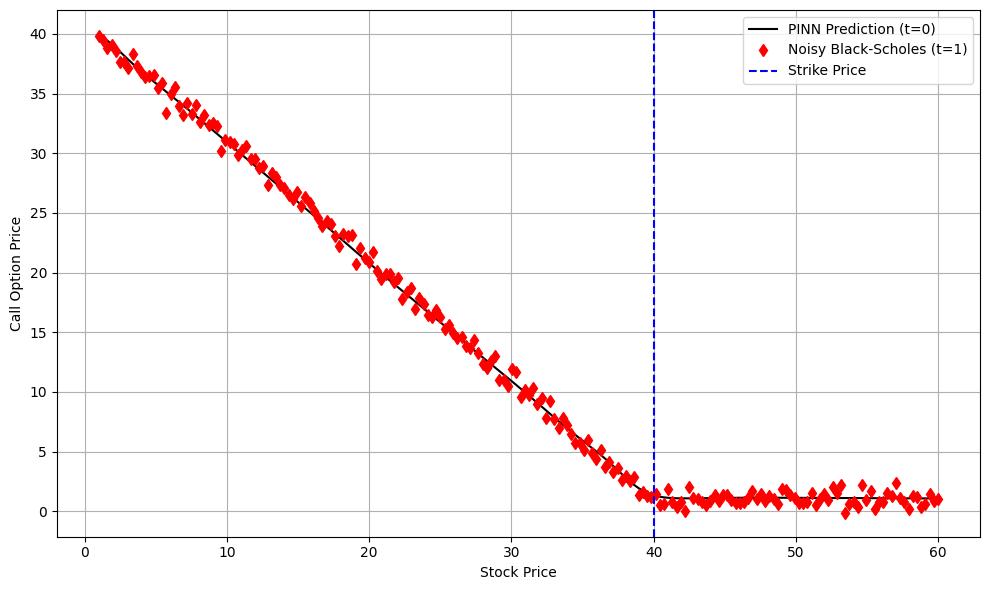

Mean Squared Error (MSE): 338.6840768992241


In [6]:
epsilon = 1e-8 
C_true = black_scholes_put_solution(S_np, config["K"], config["T"] -t + epsilon, config["r"], config["sigma"])
C_true += np.random.normal(config["bias"] , config["noise_variance"], size=C_true.shape)
plt.figure(figsize=(10, 6))
plt.plot(S_np, C_pred, label="PINN Prediction (t=0)", color='k')
plt.plot(S_np, C_true, 'd', label="Noisy Black-Scholes (t=1)",color='red')
plt.axvline(x=config["K"], color='blue', linestyle='--', label=f"Strike Price")

plt.xlabel('Stock Price')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse = np.mean((C_true - C_pred) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

[American Option Lecture Notes (Byott, 2005)](https://empslocal.ex.ac.uk/people/staff/NPByott/teaching/FinMaths/2005/american.pdf)
